Predictive accuracy is the assessment of selected models. The function is built from set S, and the model is assessed from data S.

$$ Ave_{(x,y) \epsilon T} (y - \hat{\mu_S(x)})^2$$

# Example 1

Let X, be a random variate and Y be a random variate dependent on X.

$$ X = U(0,1) $$

$$ Y = mu(x_i) + r_i $$

$$ r_i \backsim N(0,1) $$

$$ mu(x) = sin(x) $$

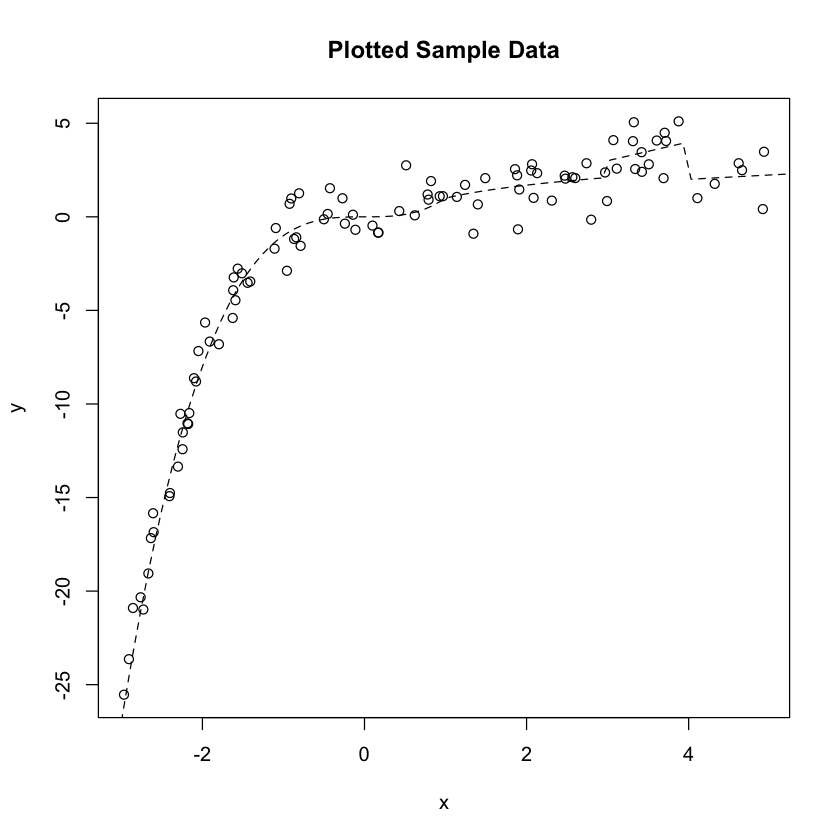

In [485]:
# generate some data
set.seed(34243411) 
n <- 100
from <- -3
to <- 5
x <- runif(n, from, to)
mu <- function(x) {
    id <- x > 1 & x < 3
    id.comp <- x<=1 
    x[id] <- log(x[id]) + 1
    x[id.comp] <- x[id.comp]^3
    id2 <- x > 4
    x[id2] <- sqrt(x[id2])
    return(x)
}
# mu <- function(x){x^3}
resids <- function(n) {rnorm(n,0,1)} 

y <- mu(x) + resids(n)
plot(x,y, main='Plotted Sample Data')
funx <- seq(from = min(x)-1, to=max(x)+1, length.out = 100)
lines(funx, mu(funx), lty=2, )

In [486]:
# Let's compute the RSS
compute.rss <- function(df.tj, y.tj, mu.hat){
 mean((y.tj - mu.hat(x))^2)   
}


In [487]:
# Try a couple of models
m1_x <- function(x0) { predict(lm(y ~x), data.frame(x=x0))}
compute.rss(x, y, m1_x)
m2_x <- function(x0) { predict(lm(y ~ sin(x)), data.frame(x=x0))}
compute.rss(x, y, m2_x)

smooth.m_x <-function(x0){ predict(smooth.spline(x = x, y = y, df = length(x) - 1), x=x0)$y}
compute.rss(x, y, smooth.m_x)

[1] 19.27817

[1] 44.93046

[1] 0.3383234

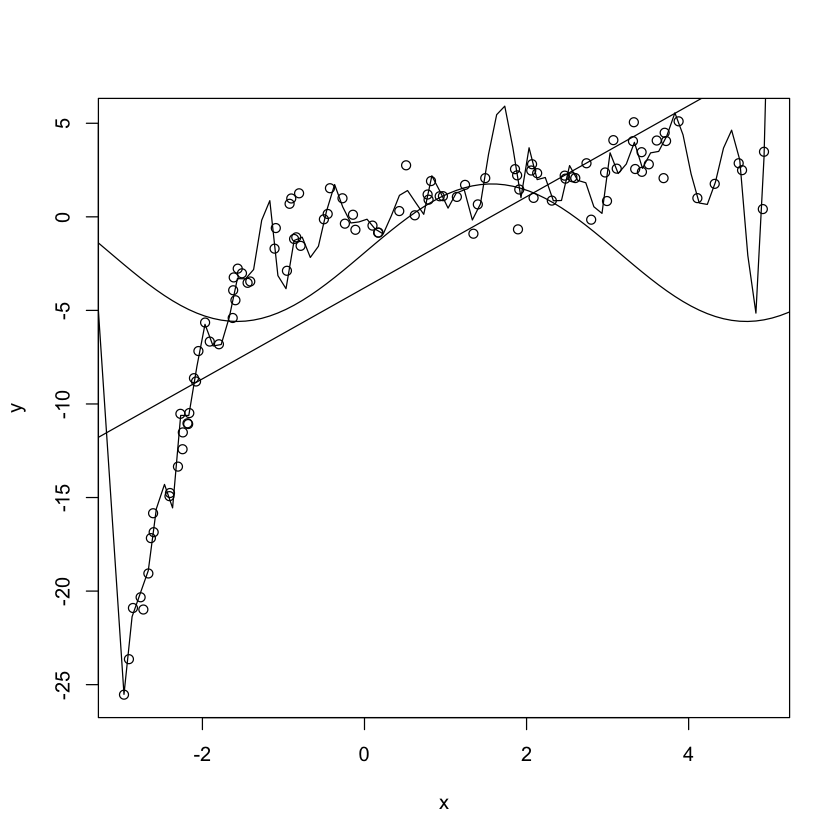

In [488]:
plot(x,y )
lines(funx,m1_x(funx))
lines(funx,m2_x(funx))
lines(funx, smooth.m_x(funx))

In [489]:
kfold <- function(N, k=N, indices=NULL){
  # get the parameters right:
  if (is.null(indices)) {
    # Randomize if the index order is not supplied
    indices <- sample(1:N, N, replace=FALSE)
  } else {
    # else if supplied, force N to match its length
    N <- length(indices)
  }
  # Check that the k value makes sense.
  if (k > N) stop("k must not exceed N")
  #
  
  # How big is each group?
  gsize <- rep(round(N/k), k)
  
  # For how many groups do we need odjust the size?
  extra <- N - sum(gsize)
  
  # Do we have too few in some groups?
  if (extra > 0) {
    for (i in 1:extra) {
      gsize[i] <- gsize[i] +1
    }
  }
  # Or do we have too many in some groups?
  if (extra < 0) {
    for (i in 1:abs(extra)) {
      gsize[i] <- gsize[i] - 1
    }
  }
  
  running_total <- c(0,cumsum(gsize))
  
  # Return the list of k groups of indices
  lapply(1:k, 
         FUN=function(i) {
           indices[seq(from = 1 + running_total[i],
                       to = running_total[i+1],
                       by = 1)
                   ]
         }
  )
}
    
    
getKFoldSamples <- function(x, y, k = 10){
    groups<- kfold(100, k =k)
    Ssamples <- lapply(groups,
                         FUN=function(group) {
                           data.frame(x=x[-group], y=y[-group])
                         })
    Tsamples <- lapply(groups,
                FUN=function(group){
                    data.frame(x=x[group], y=y[group])
                })
    list(Ssamples = Ssamples, Tsamples = Tsamples)
}

In [490]:
folds <- getKFoldSamples(x, y, k=10)

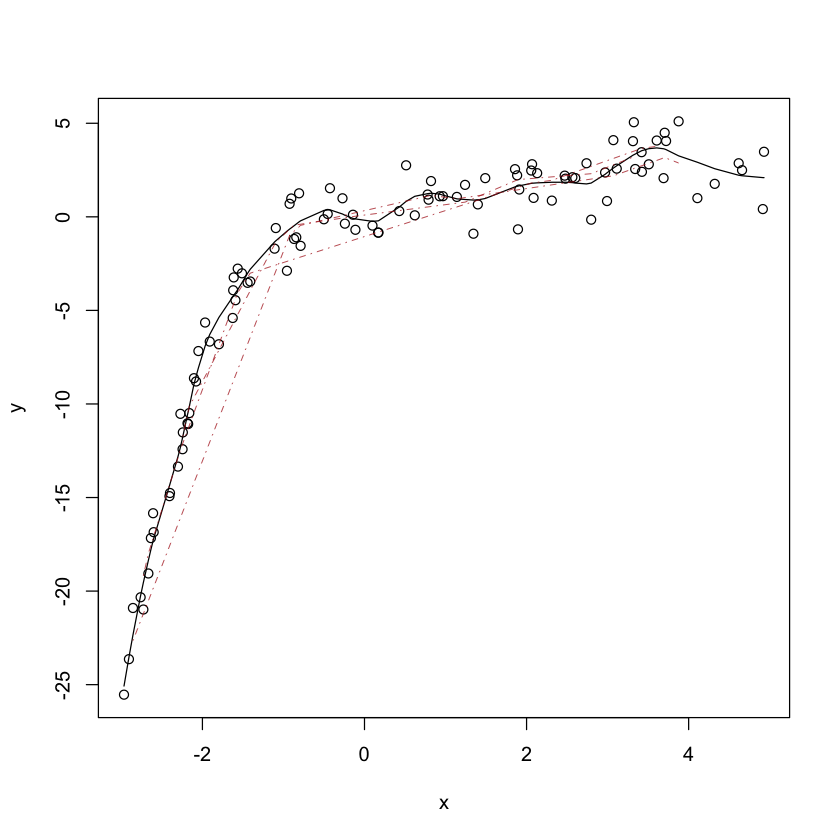

In [491]:
tryCrossValidation <- function(x,y, k = 10, verbose=FALSE,
                               predict.m = function(x, y, x.t){predict(lm(y~x), data.frame(x=x.t))}){
    folds <- getKFoldSamples(x, y, k=k)
    Ssamples <- folds$Ssamples
    Tsamples <- folds$Tsamples
    apses <- c()
    if (verbose){
        plot(x,y)
        lines(x[order(x)], predict.m(x, y, x[order(x)]))
    }
    for (i in 1:k){
        Ssamp <- Ssamples[[i]]
        Tsamp <- Tsamples[[i]]
        Xorder <- order(Tsamp$x)
        y.hat <-  predict.m(Ssamp$x, Ssamp$y, Tsamp$x[Xorder])
        apses <- c(apses, mean((Tsamp$y[Xorder] - y.hat)^2))
        if (verbose & i %% 3 == 0 ){
            lines(Tsamp$x[Xorder], y.hat, lty=4, col='firebrick', lwd = 0.6)
        }
    }
    apses
}

# exmple of the function at work!
apses.m1 <- tryCrossValidation(x, y, verbose = T, 
                              predict.m = function(x, y, xt){
                                  predict(loess(y~x, span =0.2), data.frame(x=xt)) 
                              })

In [492]:
# Try a few smoothing splines.
smoothing <- function(df){
    return(function(x,y, xt){
        predict(smooth.spline(x=x,y=y, df=df), x=xt)$y
    })
}

complexity <- 4:30
apse.sm <- sapply(complexity, FUN=function(i){
        scores <- tryCrossValidation(x, y, verbose = F, predict.m = smoothing(i))
        list(mean=mean(scores), var=var(scores))
    })


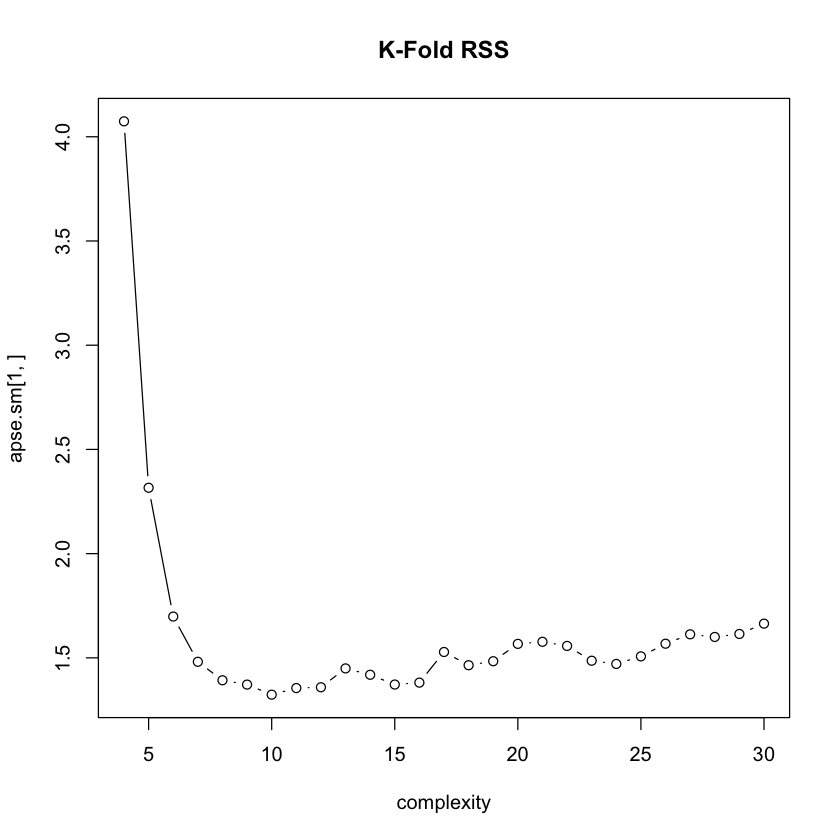

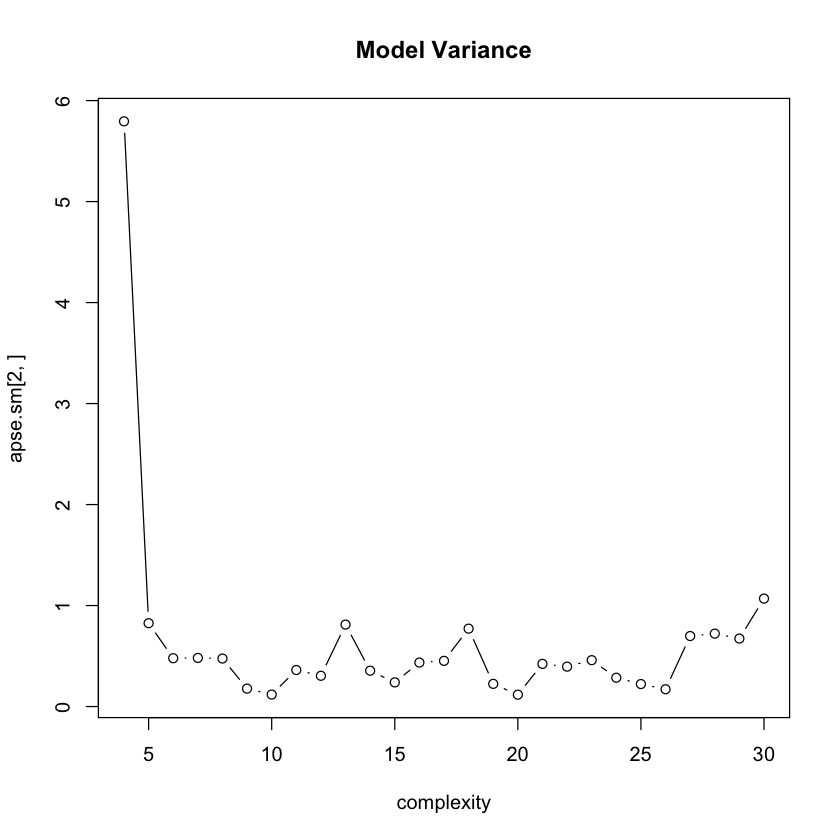

In [493]:
plot(complexity, apse.sm[1,], type='b', main='K-Fold RSS')
plot(complexity, apse.sm[2,], type='b', main='Model Variance')

In [494]:
round(spans,3)

[1] 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80
[16] 0.85 0.90 0.95 1.00

In [495]:
library(MASS)
# Try a few LOESS Models
loess.m <- function(span){
    return(function(x,y, xt){
        predict(loess(y ~ x, span=span, control=loess.control(surface="direct")), data.frame(x=xt))
    })
}

spans <- round(seq(from=0.1,to=1.0, length.out = 19),4)
apse.loes <- sapply(spans, FUN=function(i){
        scores <- tryCrossValidation(x, y, verbose = F, predict.m = loess.m(i))
        list(mean=mean(scores), var=var(scores))
    })


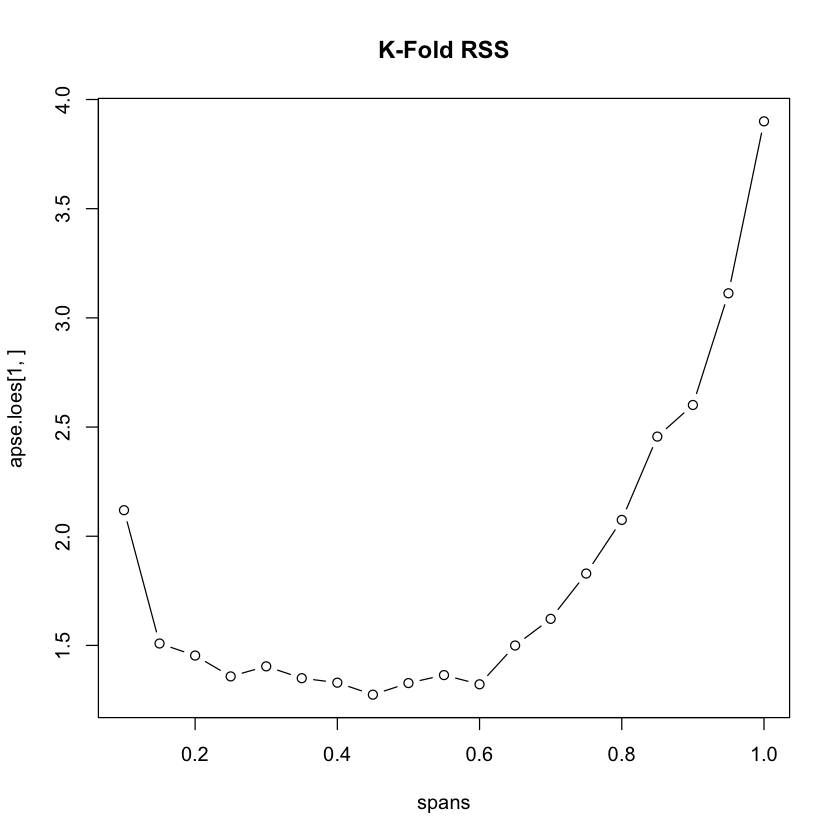

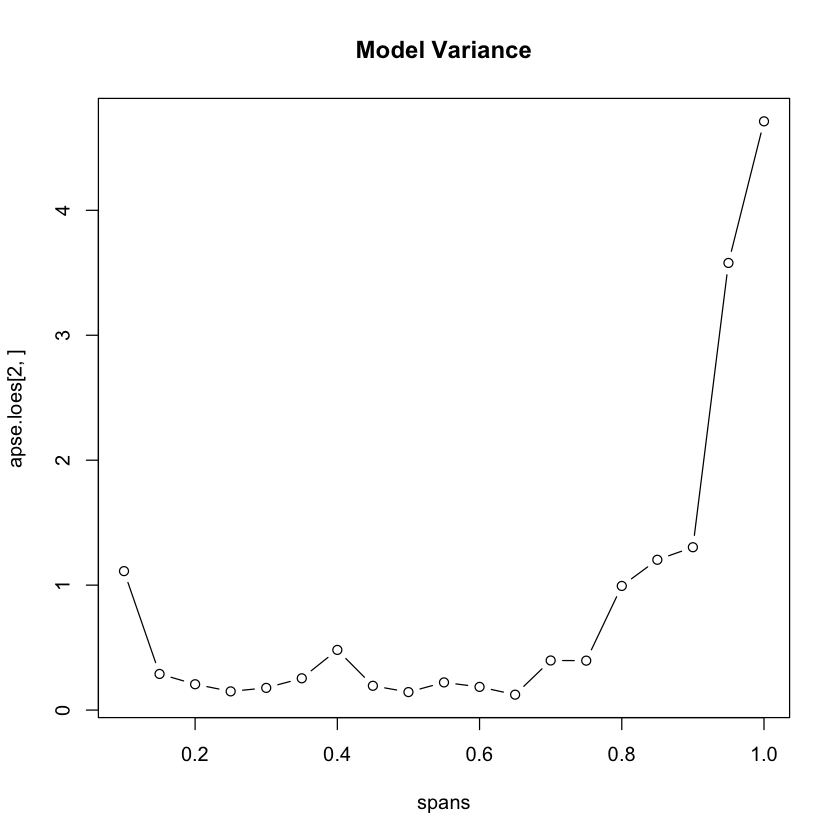

In [496]:
plot(spans, apse.loes[1,], type='b', main='K-Fold RSS')
plot(spans, apse.loes[2,], type='b', main='Model Variance')

# Cross Validate With Transforms

In [497]:

powerfun <- function(x, lambda = 0){
    if (lambda == 0){
        return(log(x))
    }else {
        return (x^(lambda))
    }
}

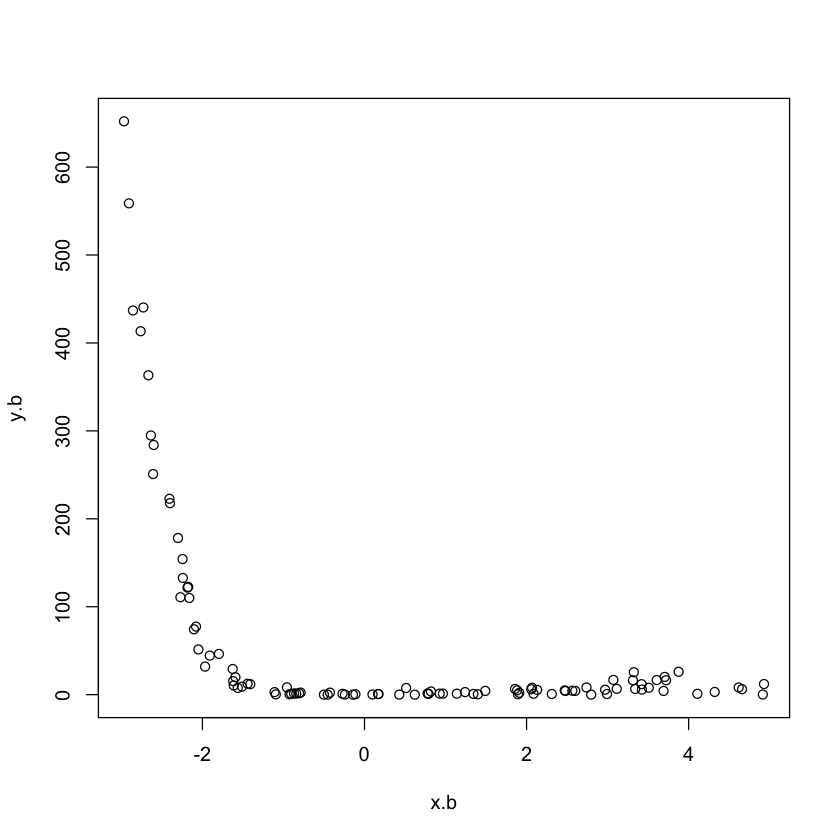

In [501]:
x.b <- powerfun(x, 1)
y.b <- powerfun(y, 2)
plot(x.b, y.b) 

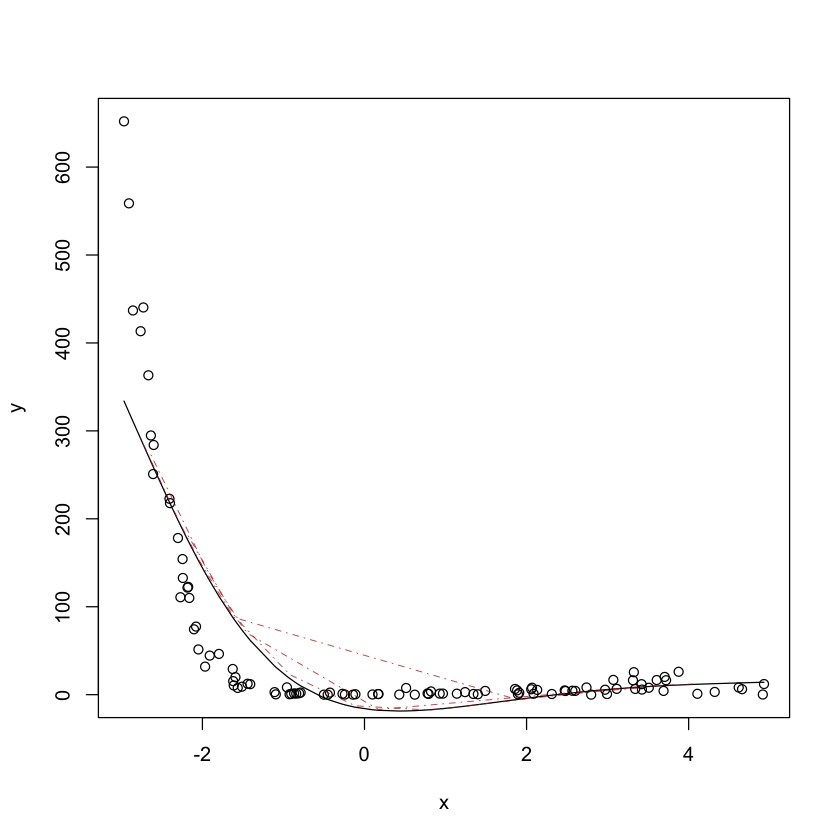

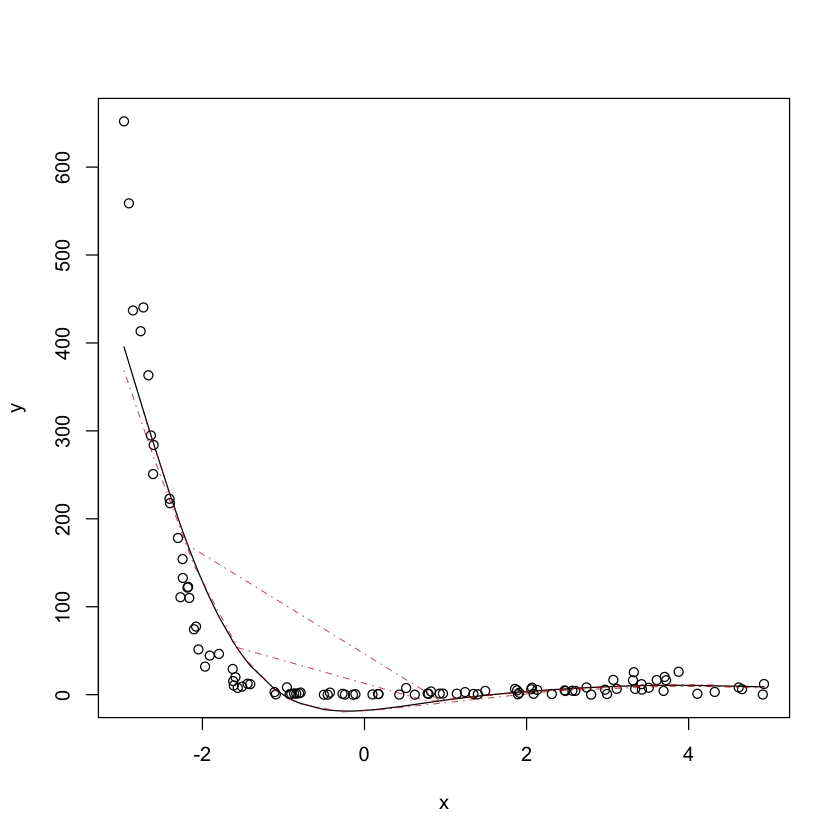

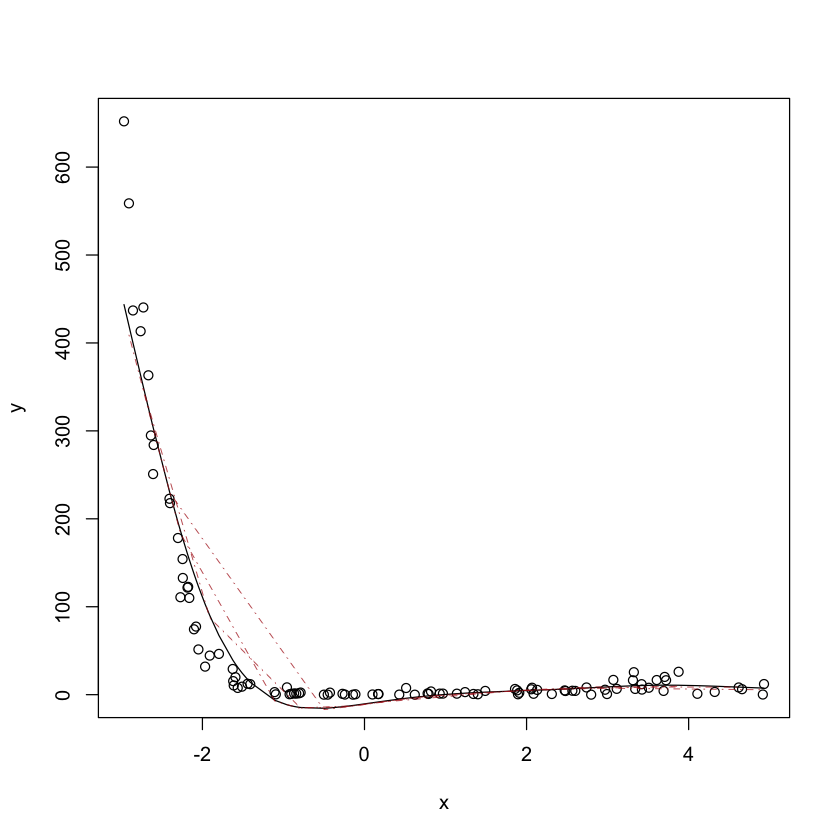

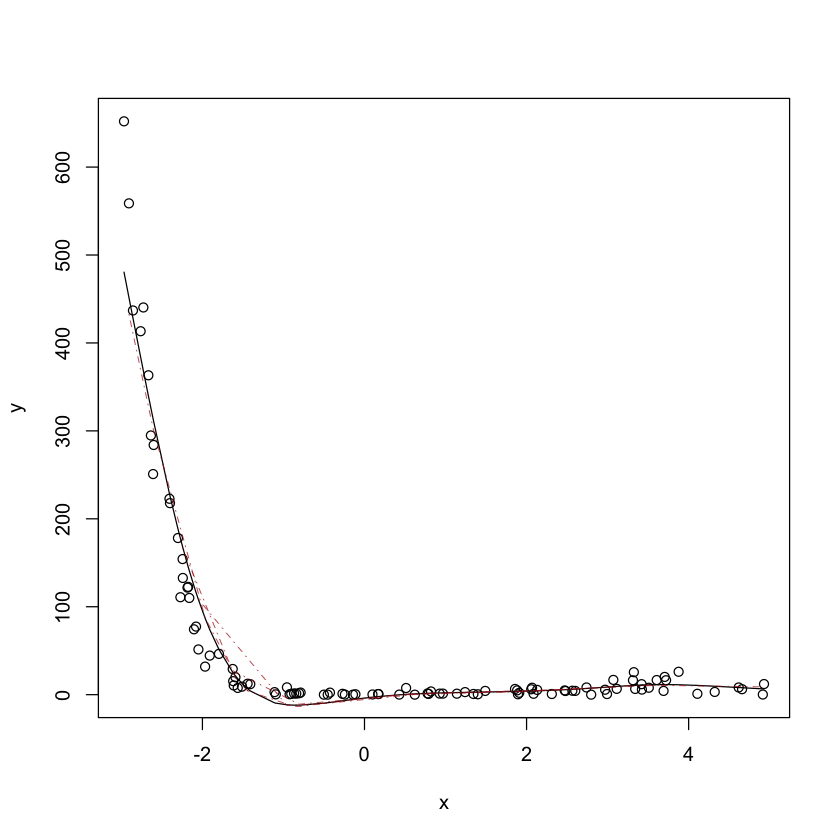

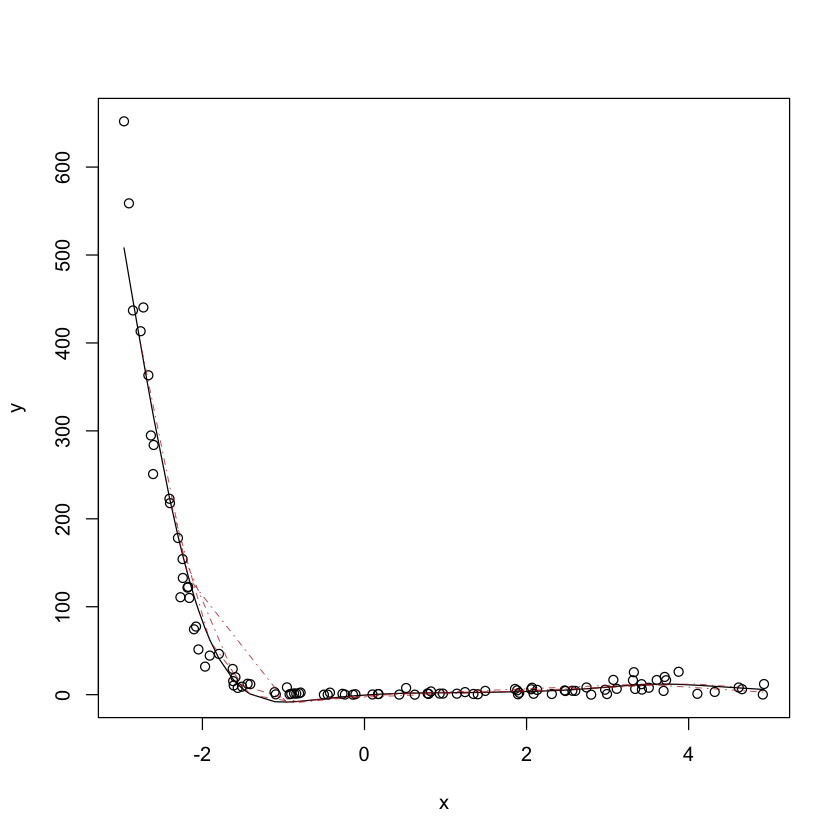

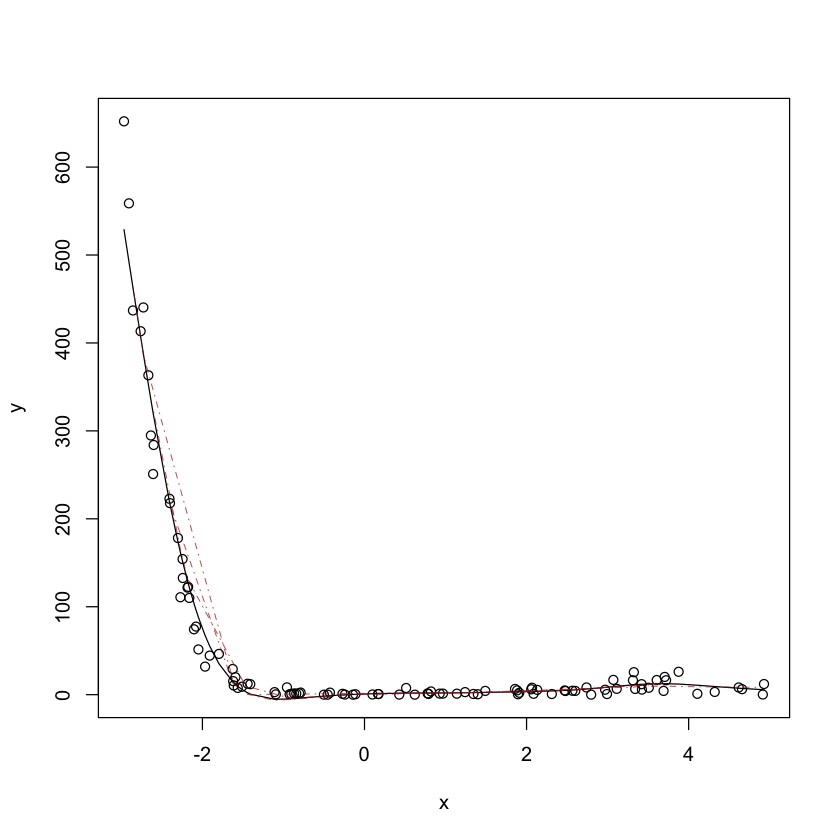

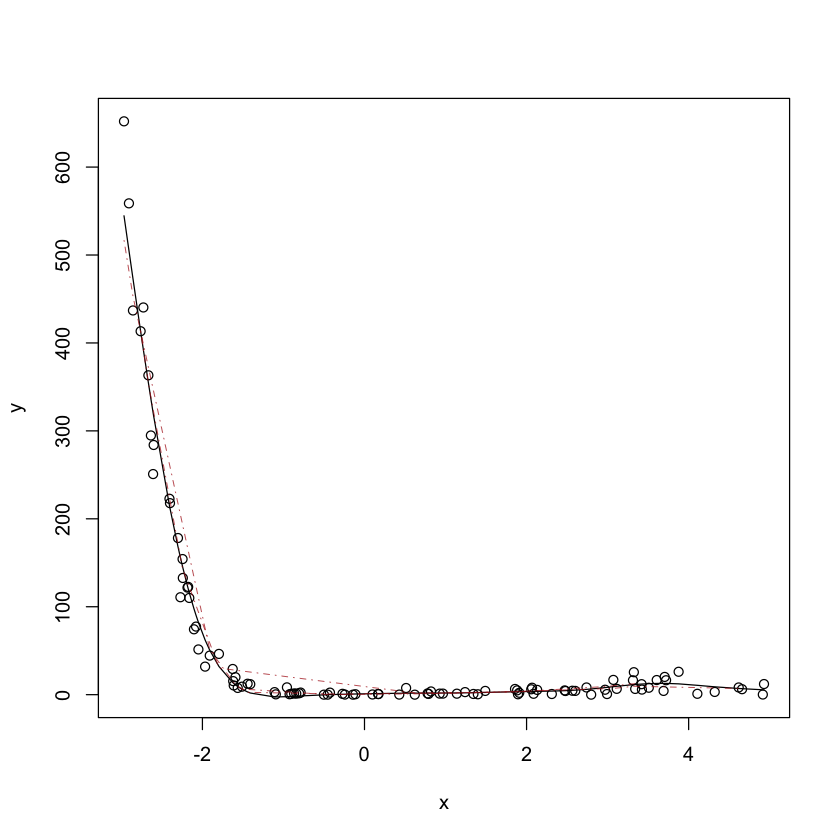

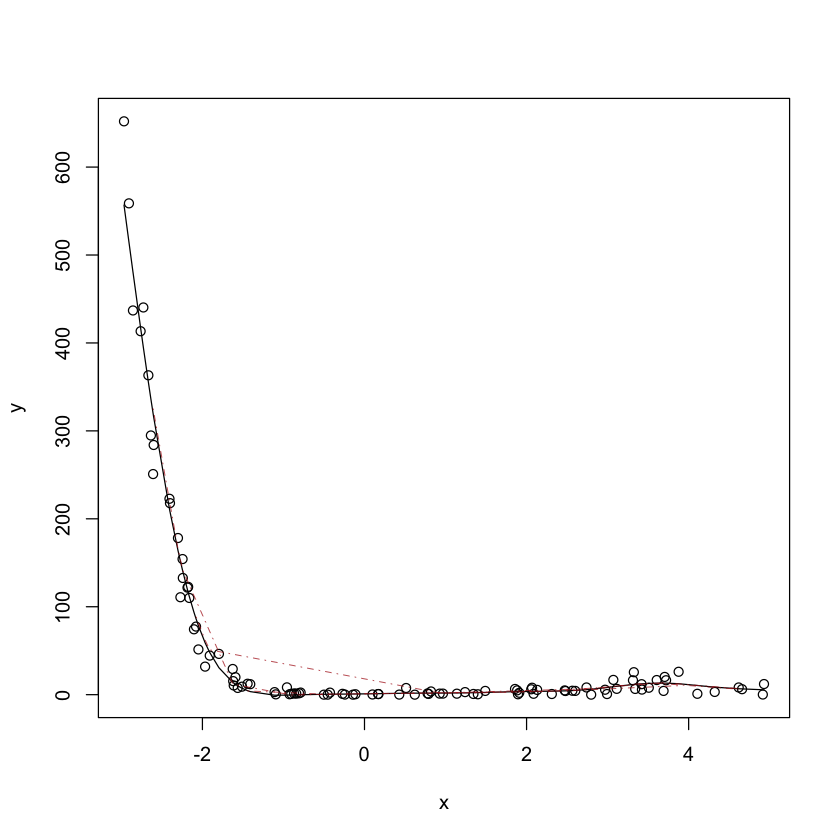

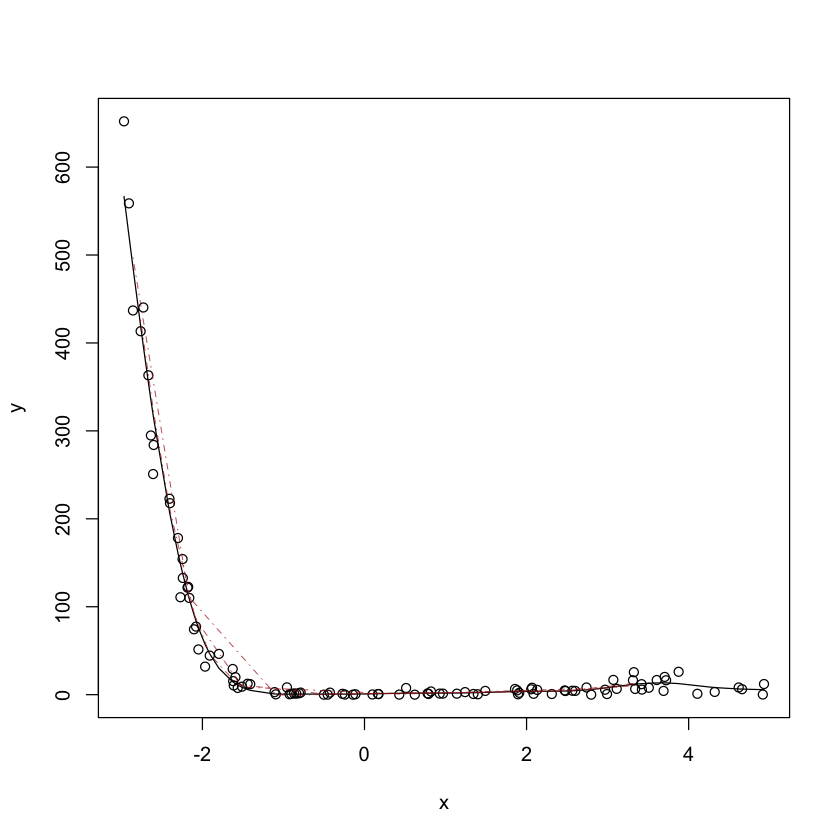

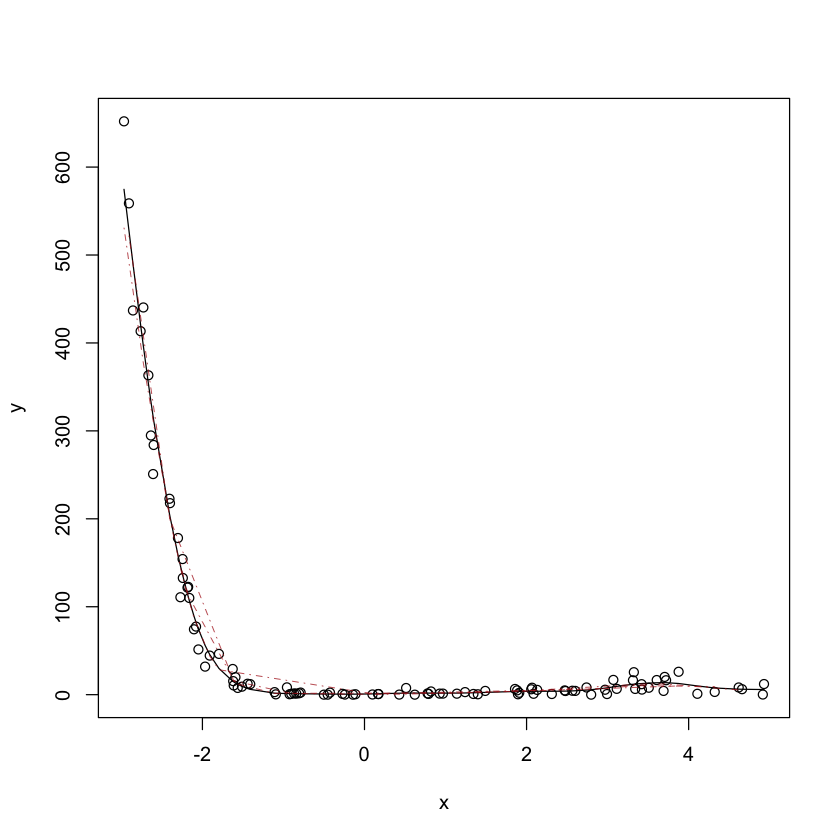

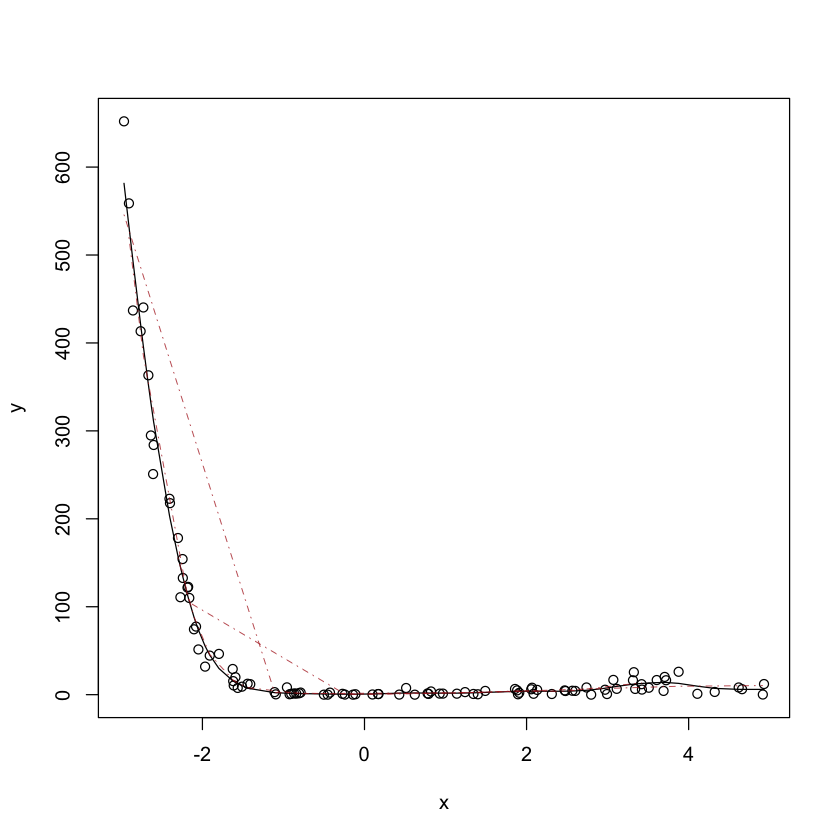

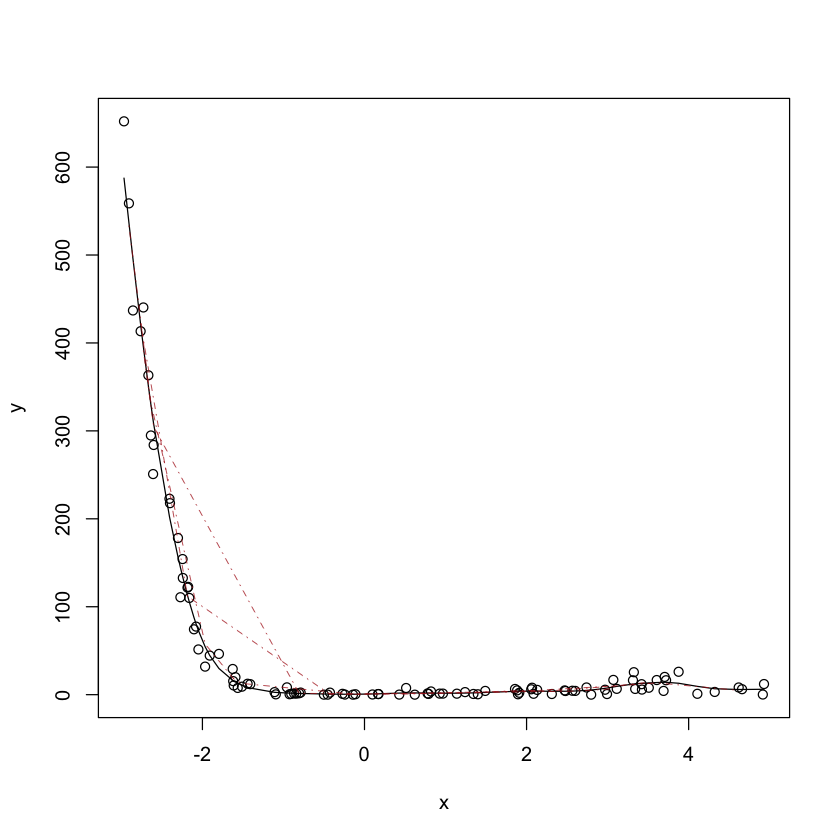

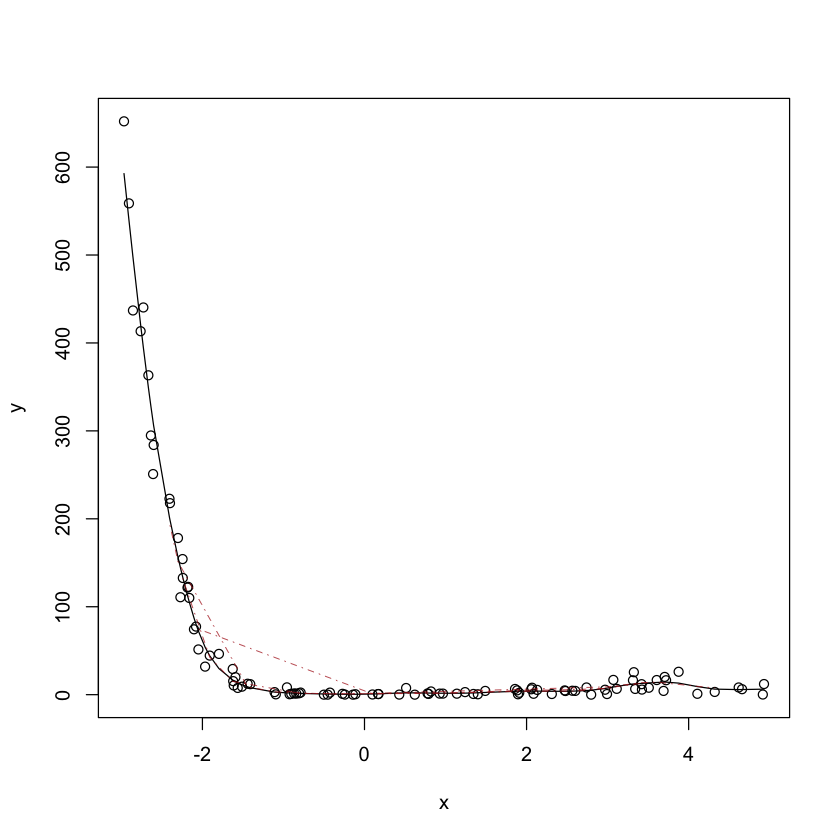

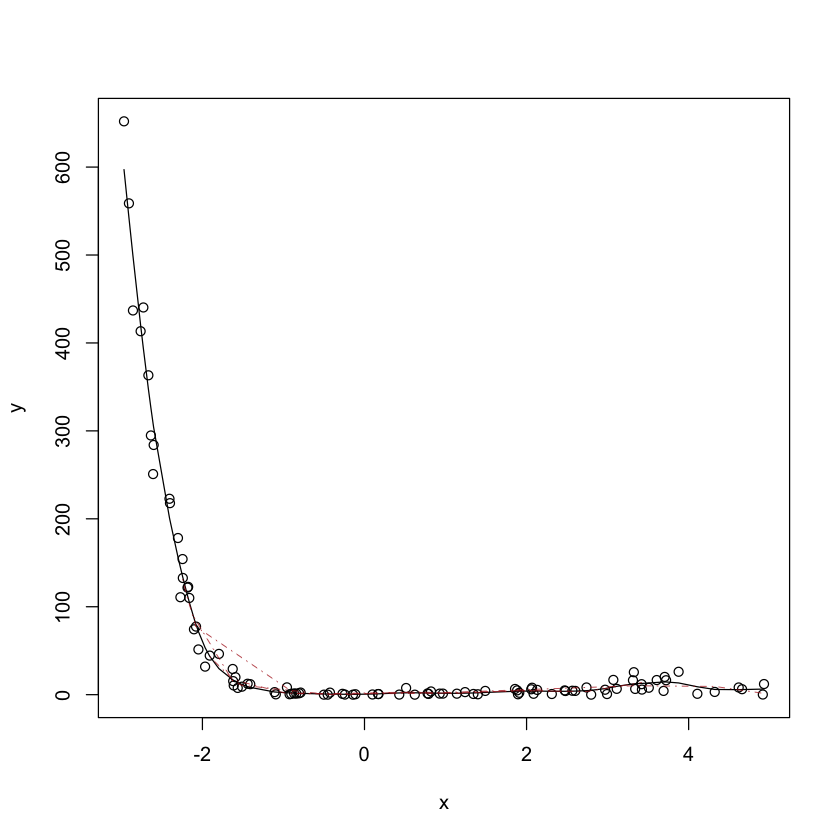

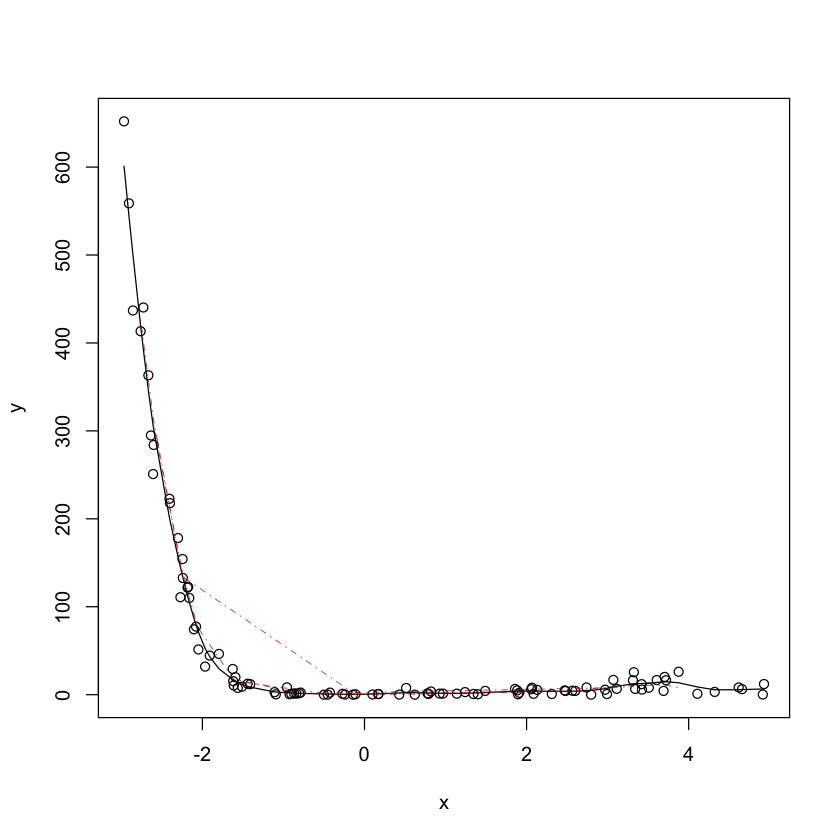

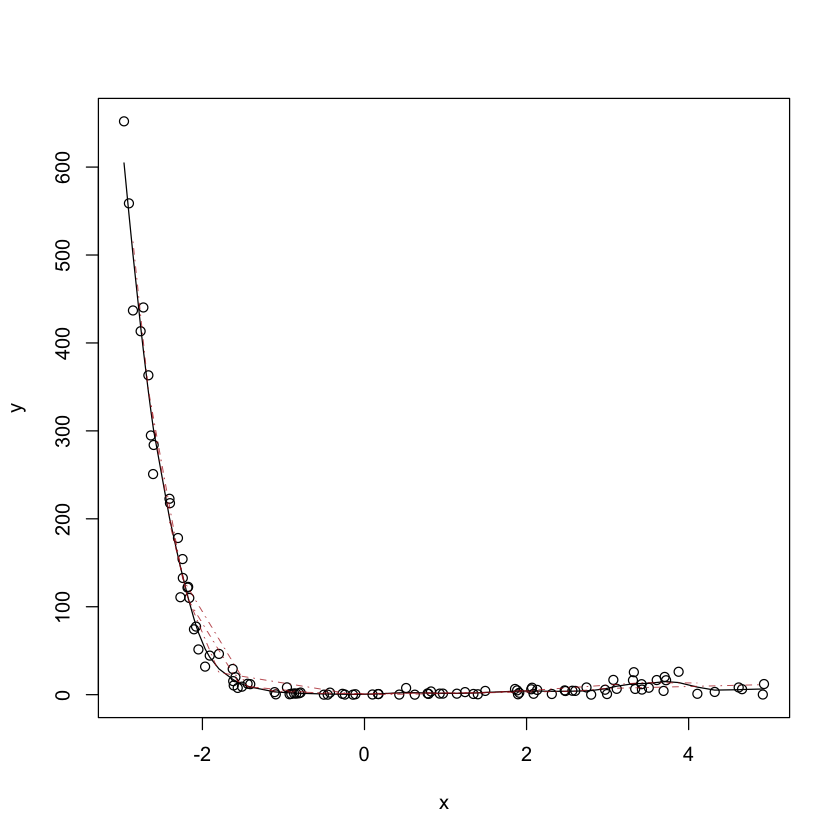

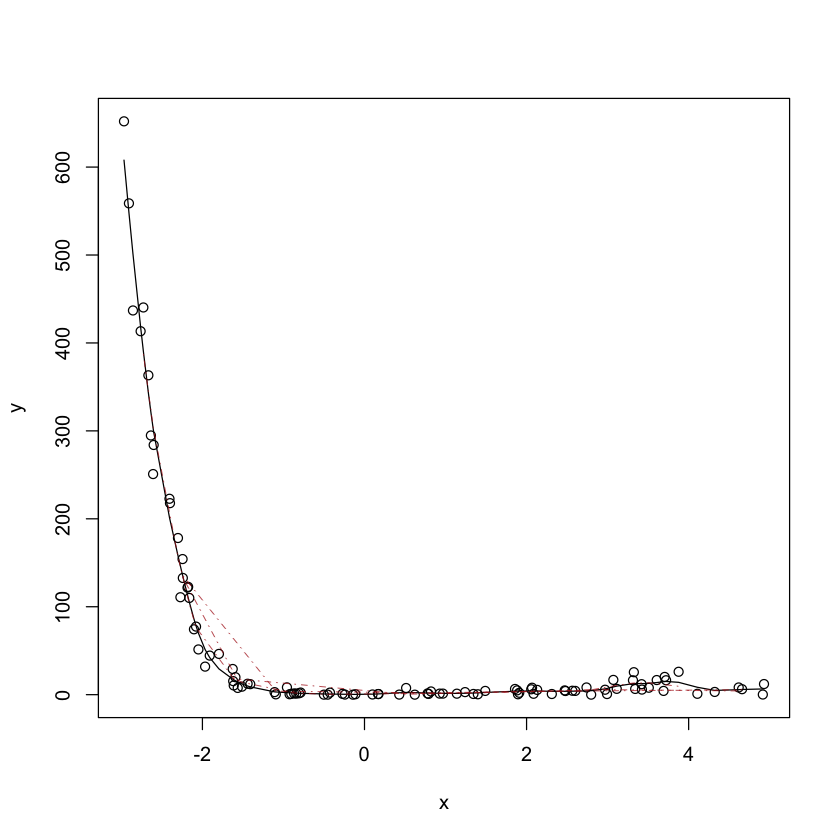

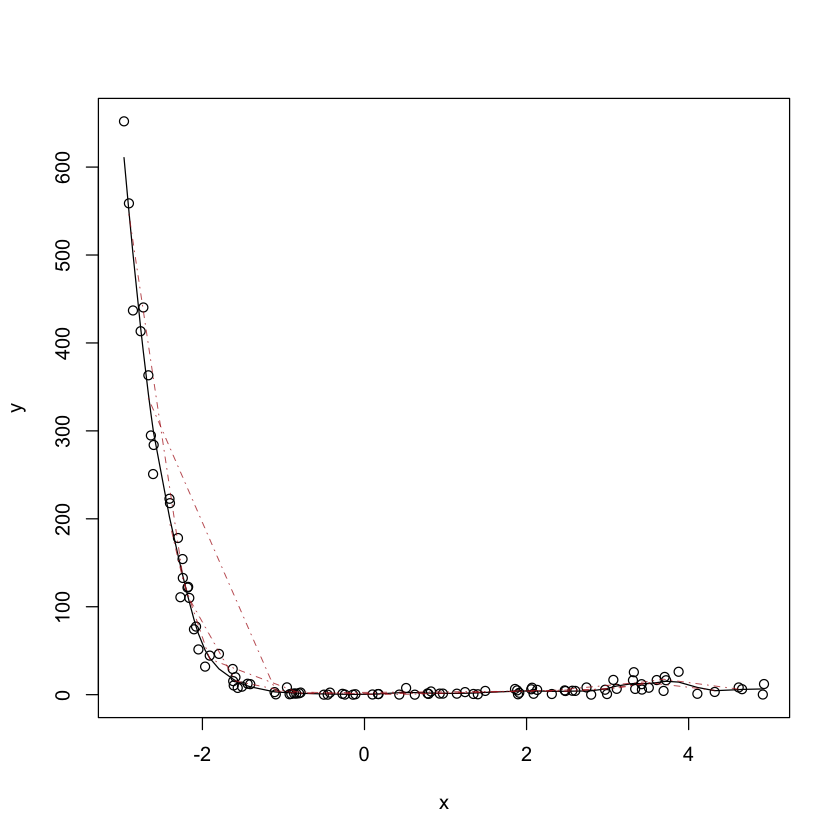

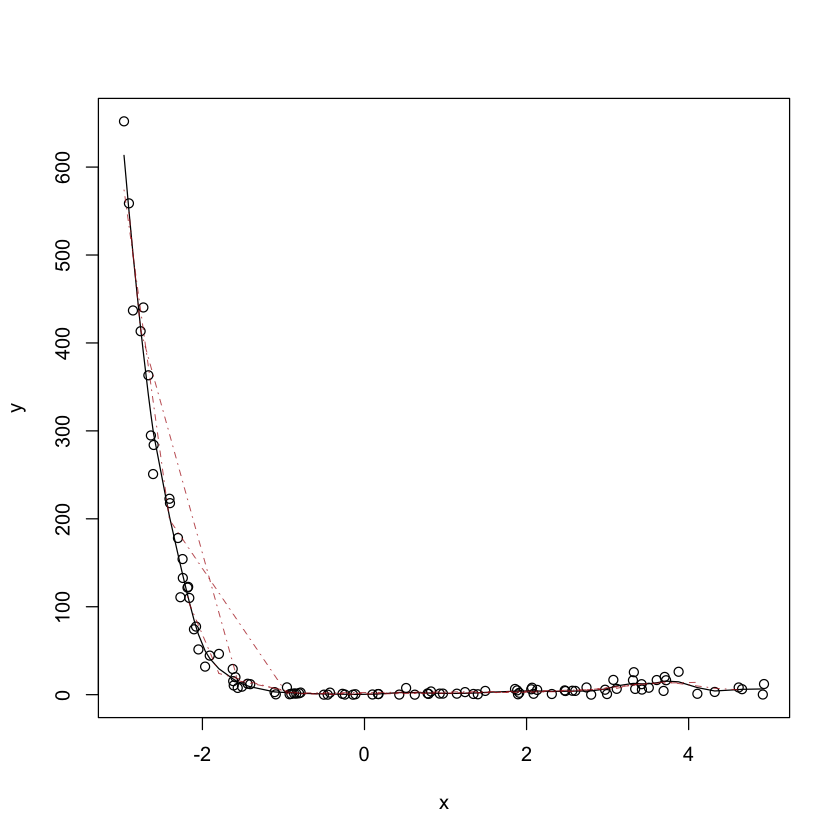

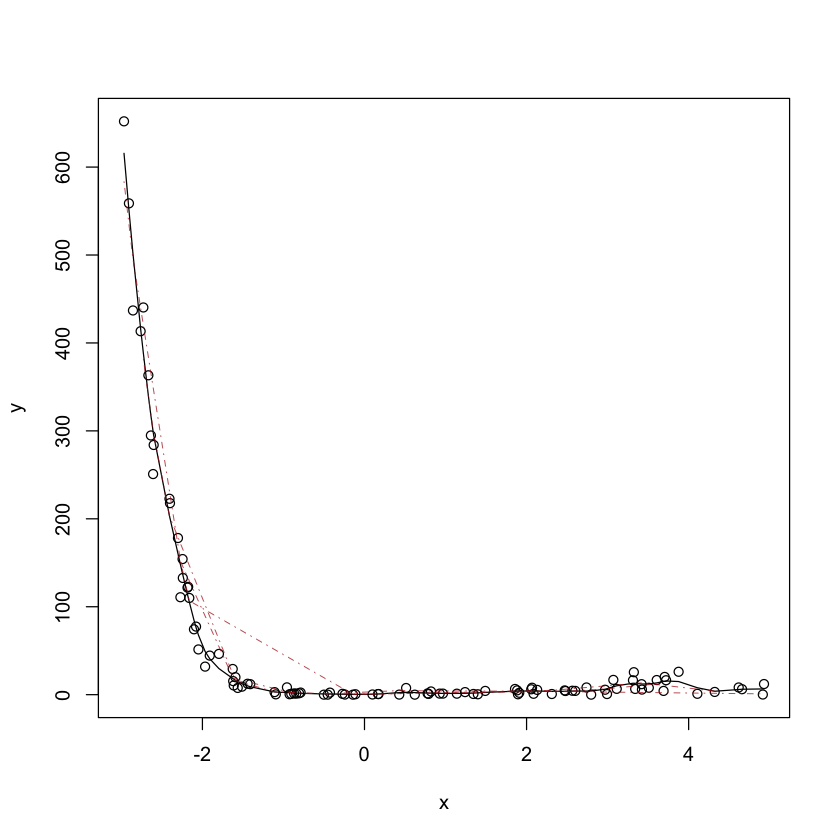

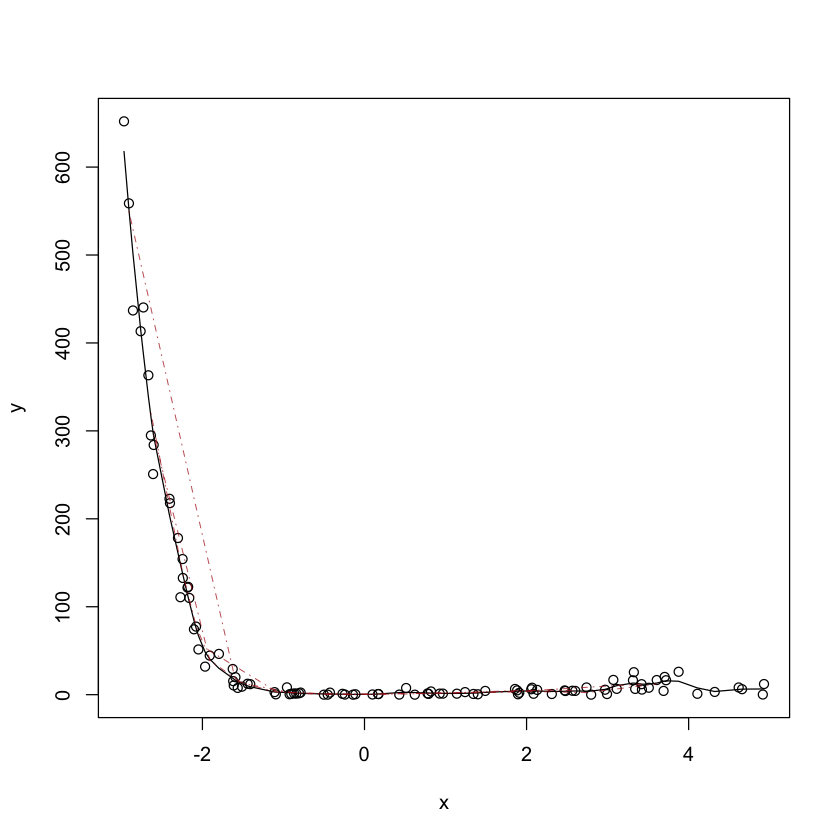

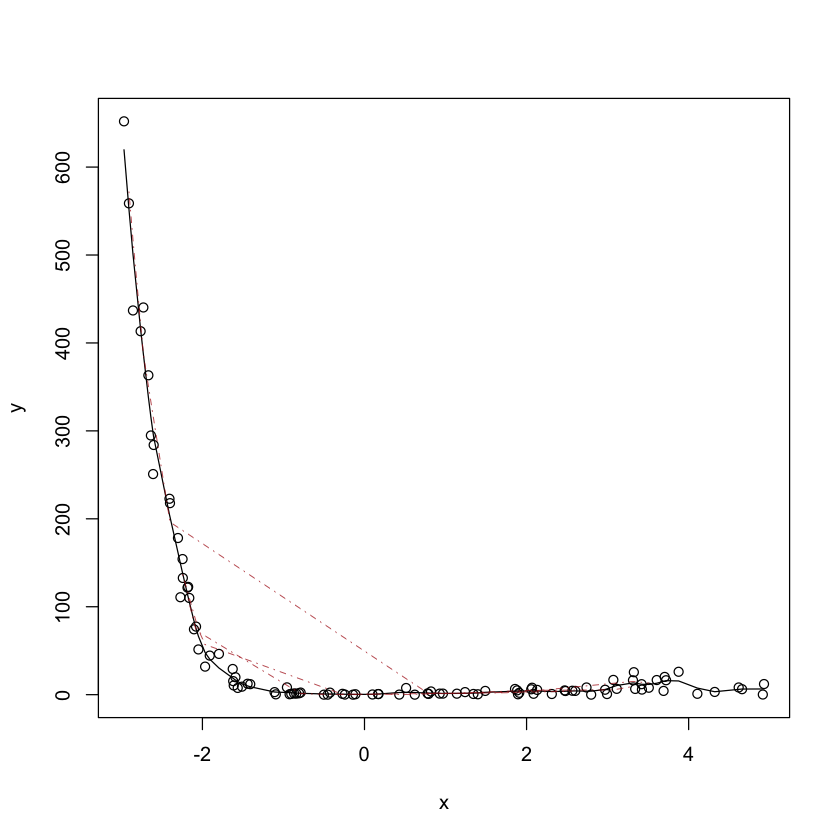

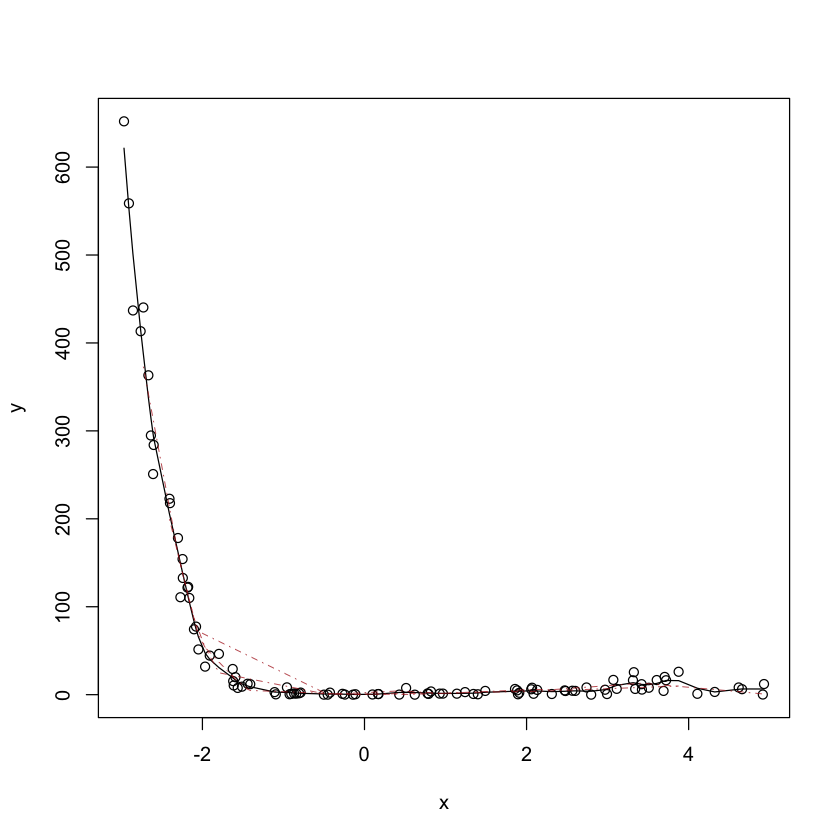

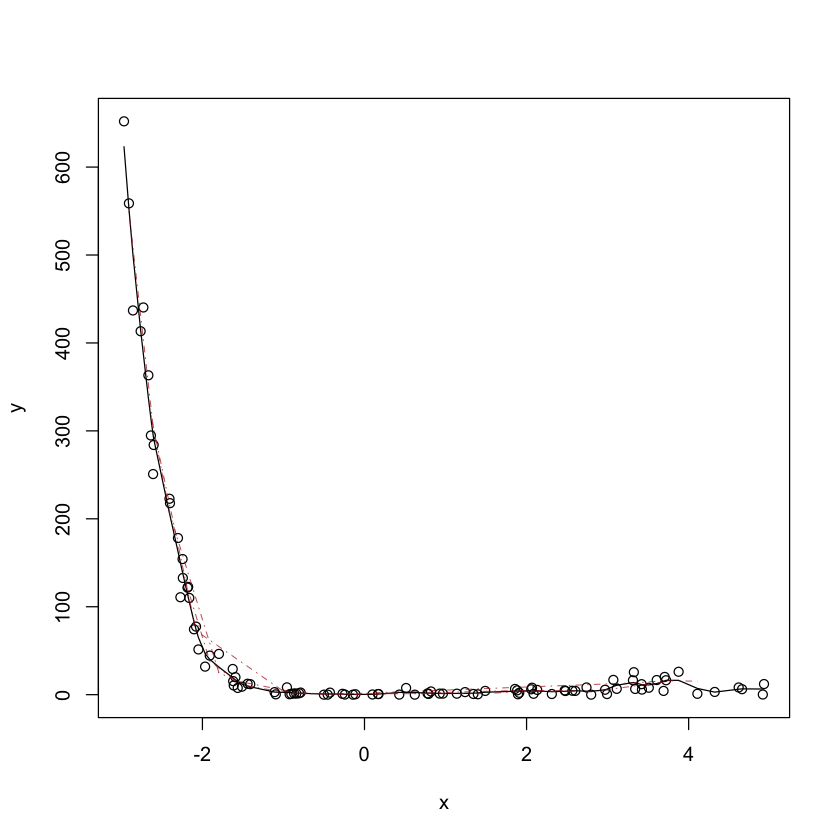

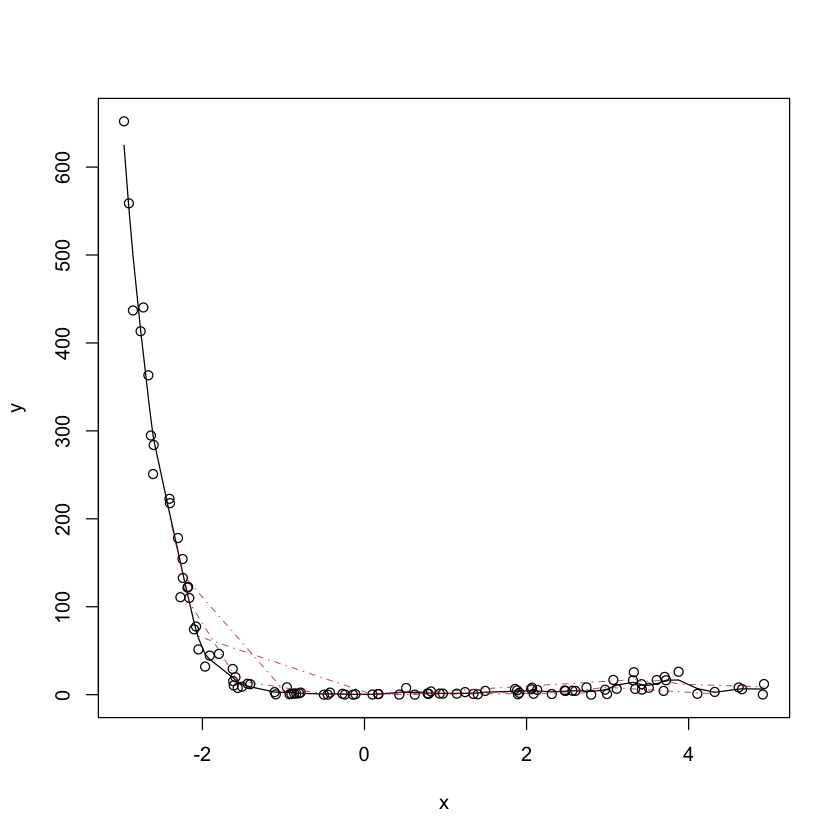

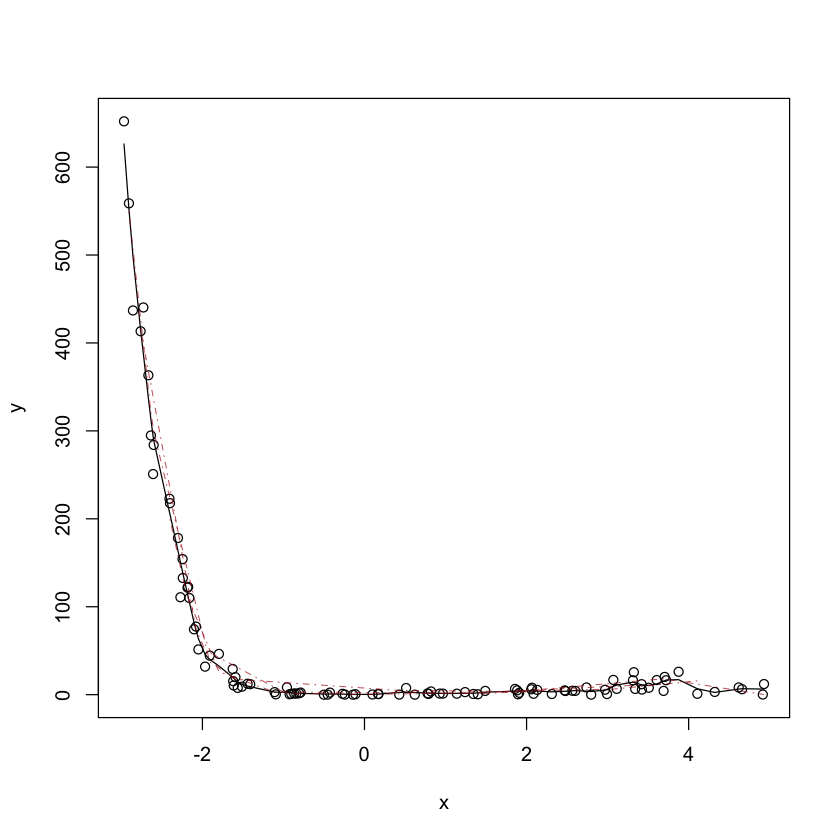

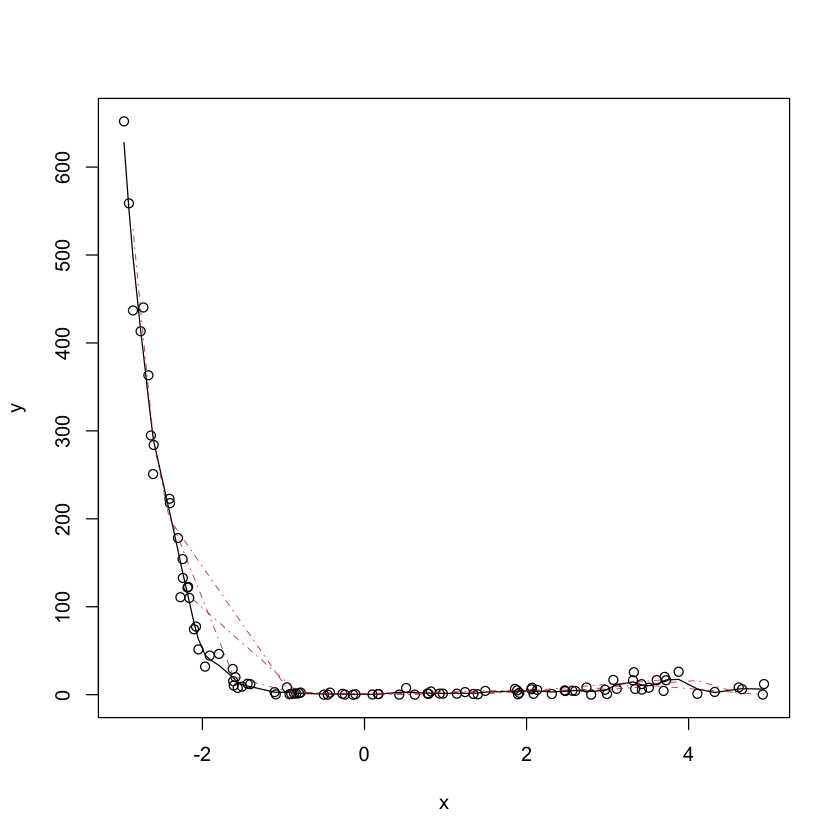

In [502]:
# Try a few smoothing splines.
smoothing <- function(df){
    return(function(x,y, xt){
        predict(smooth.spline(x=x,y=y, df=df), x=xt)$y
    })
}

complexity <- 4:30
apse.sm <- sapply(complexity, FUN=function(i){
        scores <- tryCrossValidation(x.b, y.b, verbose = T, predict.m = smoothing(i))
        list(mean=mean(scores), var=var(scores))
    })


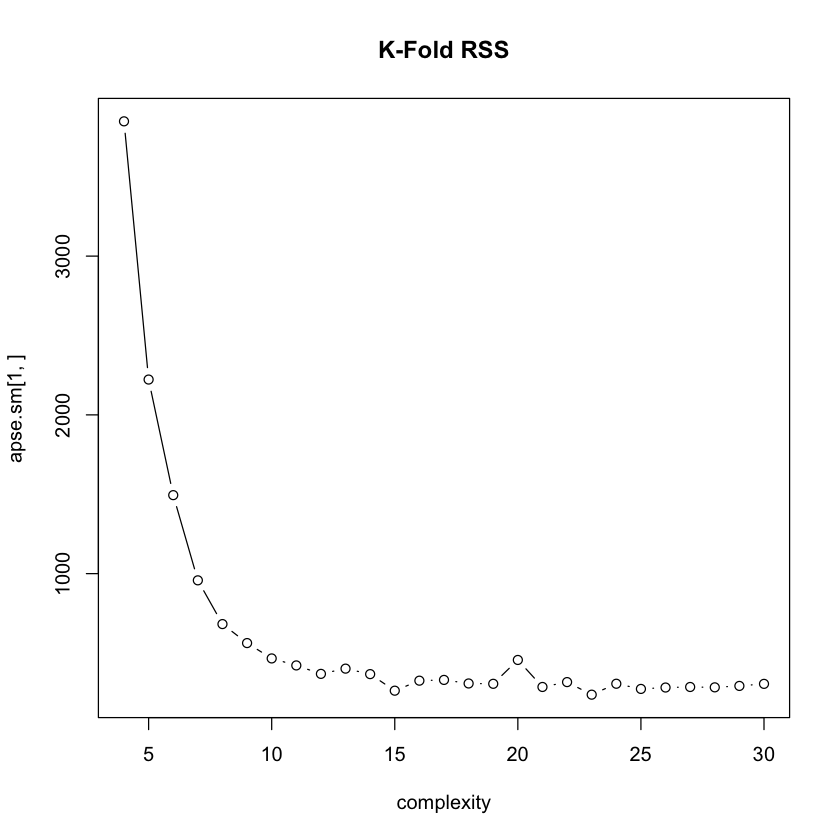

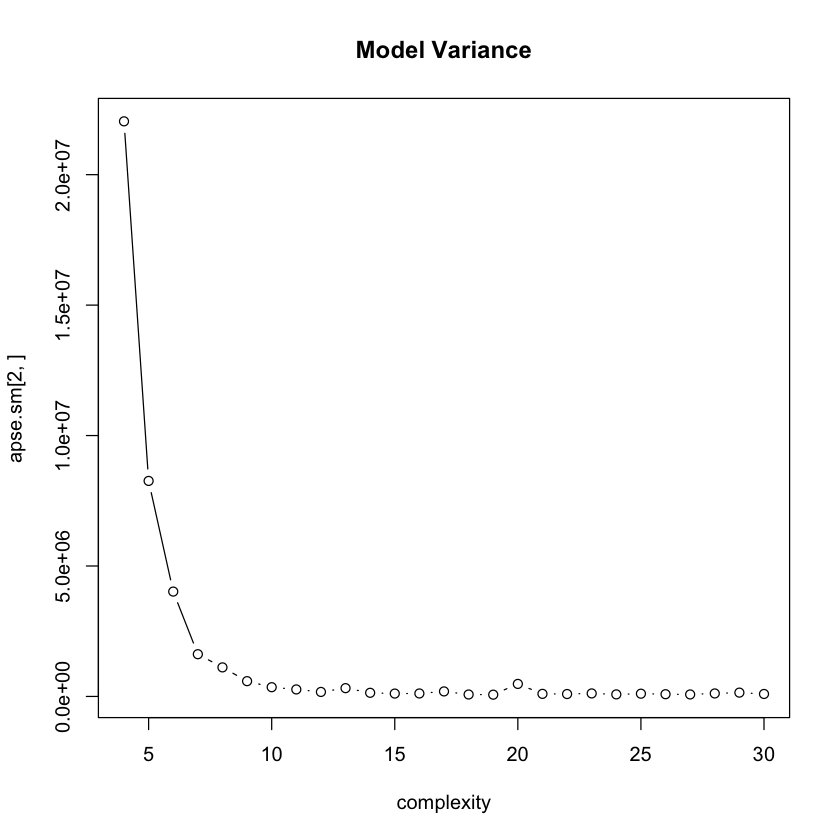

In [503]:
plot(complexity, apse.sm[1,], type='b', main='K-Fold RSS')
plot(complexity, apse.sm[2,], type='b', main='Model Variance')

# Bias and Variance of Models

In [ ]:
tryCrossValidationWithKnown <- function(x,y,mu_x, k = 10, verbose=FALSE,
                               predict.m = function(x, y, x.t){predict(lm(y~x), data.frame(x=x.t))}){
    folds <- getKFoldSamples(x, y, k=k)
    Ssamples <- folds$Ssamples
    Tsamples <- folds$Tsamples
    
    if (verbose){
        plot(x,y)
        lines(x[order(x)], predict.m(x, y, x[order(x)]))
    }
    
    for (i in 1:k){
        Ssamp <- Ssamples[[i]]
        Tsamp <- Tsamples[[i]]
        Xorder <- order(Tsamp$x)
        y.hat <-  predict.m(Ssamp$x, Ssamp$y, Tsamp$x[Xorder])
        apses <- c(apses, mean((Tsamp$y[Xorder] - y.hat)^2))
        if (verbose & i %% 3 == 0 ){
            lines(Tsamp$x[Xorder], y.hat, lty=4, col='firebrick', lwd = 0.6)
        }
    }
    apses
}

# exmple of the function at work!
apses.m1 <- tryCrossValidation(x, y, verbose = T, 
                              predict.m = function(x, y, xt){
                                  predict(loess(y~x, span =0.2), data.frame(x=xt)) 
                              })